In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae


In [2]:
## data 1, with ATAC ONE
# expr_RNA = pd.read_csv("./data/A549/self_processed/expr_rna.csv", index_col=0).values

# data 2, Paul data, give the best result
expr_RNA = pd.read_csv("./data/Paul/Paul_processed_expr.csv", index_col=0).values
cell_info = pd.read_csv("./data/Paul/Paul_cell_meta.txt", sep="\t")
clusters = cell_info['cell_type2']

# data 3, oeHBC data, small one 
# expr_RNA = pd.read_csv("./data/oeHBC/oeHBC_processed_expr.csv", sep = ",", index_col = 0).values
# clusters = pd.read_csv("./data/oeHBC/oeHBCdiff_clusterLabels.txt", sep='\t',header=None, index_col = 0, names=["cluster"])
# clusters = clusters['cluster'].astype('category')
# clusters = pd.DataFrame(clusters.cat.rename_categories(['Resting Horizontal Basal Cells (HBCs)', 'Immediate Neuronal Precursor 1 (INP1)', 'Globose Basal Cells (GBCs)', 'Mature Sustentacular Cells','Transitional HBC 2', 'Immature Sustentacular Cells', 'Transitional HBC 1', 'Immature Olfactory Sensory Neurons (iOSNs)', 'Immediate Neuronal Precursor 3 (INP3)', 'Microvillous Cells, type 1', 'Mature Olfactory Sensory Neurons (mOSNs)', 'Immediate Neuronal Precursor 2 (INP2)', 'Microvillous Cells, type 2']))

# data 4, linear dataset, forbrain
# expr_RNA = pd.read_csv("./data/forebrain/forebrain_processed_expr.csv", sep = ",", index_col = 0).values
# velo_RNA = pd.read_csv("./data/forebrain/forebrain_processed_velocity.csv", sep = ",", index_col = 0).values

In [3]:
data_tensor = torch.FloatTensor(expr_RNA)

In [4]:
# diffu_RNA = diff.diffusion_map(expr_RNA, n_eign = None, alpha = 200, diffusion_time = 5)
# diff_sim = diff.diffusion_similarity(diffu_RNA)
# fig = plt.figure(figsize = (20,10))
# ax = fig.add_subplot()
# ax.scatter(diffu_RNA[:,2], diffu_RNA[:,3], c=np.arange(diffu_RNA.shape[0]))

# DPT distance
DPT_RNA = diff.DPT_similarity(expr_RNA)
# Phate distance
Phate_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = True)
# Diffmap distance
Diffmap_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = False)

In [5]:
DPT_tensor = torch.FloatTensor(DPT_RNA)
Phate_tensor = torch.FloatTensor(Phate_RNA)
Diffmap_tensor = torch.FloatTensor(Diffmap_RNA)

In [6]:
def traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1):
    loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    
    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    
    latent_sim = pairwise_distance(z)
        
    # normalize latent similarity matrix
    latent_sim = latent_sim / torch.norm(latent_sim, p='fro')

    # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
    loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 
    

    loss = loss_recon + loss_dist
    return loss, loss_recon, loss_dist

In [7]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    dist = torch.sqrt(dist + 1e-5)
    return dist 

In [8]:
class scDataset(Dataset):
    
    def __init__(self, rna_seq_file = "./data/Paul/Paul_processed_expr.csv"):
        self.expr_RNA = torch.FloatTensor(pd.read_csv(rna_seq_file, index_col=0).values)
        
        
    def __len__(self):
        # number of cells
        return len(self.expr_RNA)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # index denote the index of the cell
        sample = {'RNA':self.expr_RNA[idx,:], 'index':idx}
        
        return sample

In [9]:
dataset = scDataset()
train_loader = DataLoader(dataset, batch_size = 256, shuffle = True)
test_loader = DataLoader(dataset, batch_size = len(dataset), shuffle = False)

In [16]:
def train_model(model, data_loader, diff_sim, n_epochs = 1000, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1):

    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    step = 0
    for epoch in range(n_epochs):
        for data in data_loader:
            batch_cols = data['index']
            batch_sim = diff_sim[batch_cols,:][:,batch_cols]
            batch_expr = data['RNA']
            batch_expr_r = model(batch_expr)
            z = model[:1](batch_expr)
            
            train_loss, loss_recon, loss_dist = traj_loss(batch_expr_r, batch_expr, z, batch_sim, lamb_r, lamb_d)
            
            loss_recon.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        if epoch % 10 == 0:
            print("train loss: ", train_loss.item(), "loss_recon:", loss_recon.item(), "loss_dist:", loss_dist.item())
    
    return model

In [17]:
CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
}


encoder = ae.Encoder(cfg = CONFIG)
decoder = ae.Decoder(cfg = CONFIG)

In [ ]:
auto_encoder = nn.Sequential(encoder, decoder)
auto_encoder = train_model(auto_encoder, train_loader, DPT_tensor, learning_rate = 1e-4, lamb_r = 0, lamb_d = 0.01)

train loss:  -5.3483734130859375 loss_recon: 0.0 loss_dist: -5.3483734130859375
train loss:  -5.777475833892822 loss_recon: 0.0 loss_dist: -5.777475833892822
train loss:  -5.781642913818359 loss_recon: 0.0 loss_dist: -5.781642913818359
train loss:  -5.907253265380859 loss_recon: 0.0 loss_dist: -5.907253265380859
train loss:  -5.181342601776123 loss_recon: 0.0 loss_dist: -5.181342601776123
train loss:  -5.033445358276367 loss_recon: 0.0 loss_dist: -5.033445358276367
train loss:  -5.416175842285156 loss_recon: 0.0 loss_dist: -5.416175842285156
train loss:  -5.549309730529785 loss_recon: 0.0 loss_dist: -5.549309730529785
train loss:  -5.239272117614746 loss_recon: 0.0 loss_dist: -5.239272117614746
train loss:  -5.936159133911133 loss_recon: 0.0 loss_dist: -5.936159133911133
train loss:  -5.082114219665527 loss_recon: 0.0 loss_dist: -5.082114219665527
train loss:  -5.016848087310791 loss_recon: 0.0 loss_dist: -5.016848087310791
train loss:  -5.374983310699463 loss_recon: 0.0 loss_dist: -5.

# old

In [31]:
# layers will be input -> 100 -> 2 --> 100 -> output
n_features = data_tensor.shape[1]

hidden_layer1 = nn.Linear(in_features=n_features, out_features= 512)
batch_norm1 = nn.BatchNorm1d(num_features = 512)
relu_1 = nn.ReLU()
lrelu_1 = nn.LeakyReLU(negative_slope = 0.2)

hidden_layer2 = nn.Linear(in_features=512, out_features= 256)
batch_norm2 = nn.BatchNorm1d(num_features = 256)
relu_2 = nn.ReLU()
lrelu_2 = nn.LeakyReLU(negative_slope = 0.2)

hidden_layer3 = nn.Linear(in_features=256, out_features=128)
batch_norm3 = nn.BatchNorm1d(num_features = 128)
relu_3 = nn.ReLU()
lrelu_3 = nn.LeakyReLU(negative_slope = 0.2)

hidden_layer4 = nn.Linear(in_features=128, out_features=2)


hidden_layer5 = nn.Linear(in_features=2, out_features=128)
batch_norm5 = nn.BatchNorm1d(num_features = 128)
relu_5 = nn.ReLU()
lrelu_5 = nn.LeakyReLU(negative_slope = 0.2)

hidden_layer6 = nn.Linear(in_features=128, out_features=256)
batch_norm6 = nn.BatchNorm1d(num_features = 256)
relu_6 = nn.ReLU()
lrelu_6 = nn.LeakyReLU(negative_slope = 0.2)

hidden_layer7 = nn.Linear(in_features=256, out_features=512)
batch_norm7 = nn.BatchNorm1d(num_features = 512)
relu_7 = nn.ReLU()
lrelu_7 = nn.LeakyReLU(negative_slope = 0.2)

output_layer8 = nn.Linear(in_features=512, out_features=n_features)

In [13]:
# autoencoder2 = nn.Sequential(hidden_layer1,
#                             batch_norm1,
#                             lrelu_1,
#                             hidden_layer2,
#                             batch_norm2,
#                             lrelu_2,
#                             hidden_layer3,
#                             batch_norm3,
#                             lrelu_3,  
#                             hidden_layer4, 
                             
#                             hidden_layer5,
#                             batch_norm5,
#                             lrelu_5,
#                             hidden_layer6,
#                             batch_norm6,
#                             lrelu_6,
#                             hidden_layer7,
#                             batch_norm7,
#                             lrelu_7,
#                             output_layer8
#                             )

# autoencoder2 = train_model(autoencoder2, data_tensor, DPT_sim, n_epochs = 2000, learning_rate=1e-3)

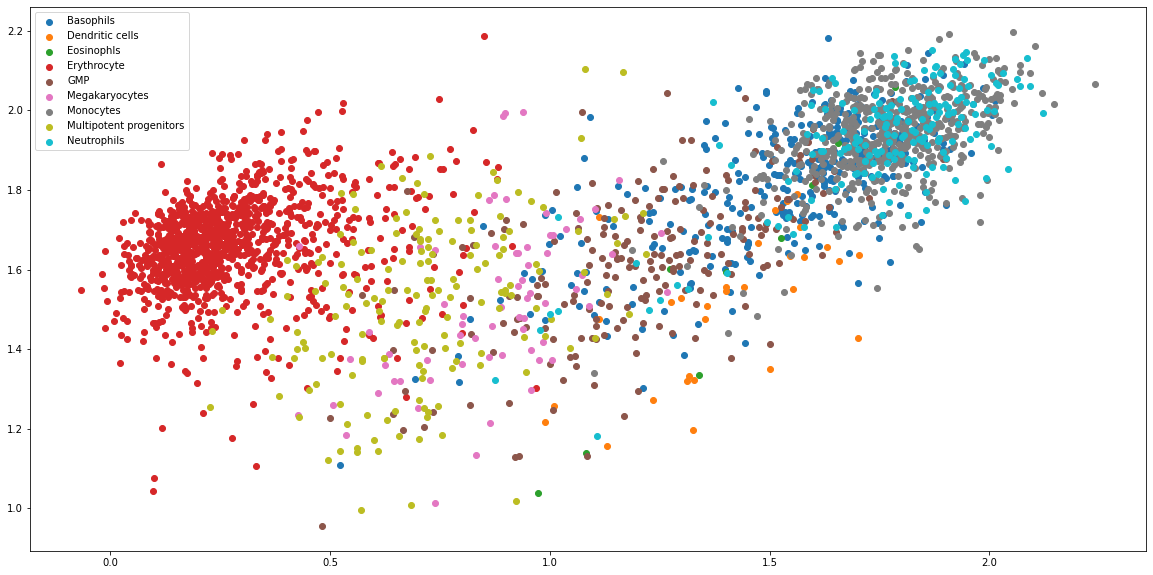

In [17]:
with torch.no_grad():
    ae_coordinates = autoencoder1[:3](data_tensor).numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

# data 3, oeHBC data, small one 
cluster_types = np.unique(clusters.values)
colormap = plt.cm.get_cmap("tab10", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(clusters.values == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types) 